In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [87]:
time_slice_size = 3600*9
#5000 second slices

In [88]:
cat_df = pd.read_csv("catalogs/apollo12_catalog_GradeA_final.csv")
data_path = "data/"

activity_detected = 0

i = 0

for filename in cat_df["filename"]:
    try:
        df = pd.read_csv(data_path + filename + ".csv")
        activity_detected = cat_df["time_rel(sec)"][i]
        if(i>=19):
            break
    except(FileNotFoundError):
        continue
    i+=1


In [89]:
filename

'xa.s12.00.mhz.1971-03-25HR00_evid00028'

In [90]:
cleaned_df = df.drop(['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], axis=1)

In [91]:
scalar = StandardScaler()
normalized_df = scalar.fit_transform(cleaned_df.values)
normalized_df

array([[-1.73204778,  0.00287469],
       [-1.73204173,  0.00287437],
       [-1.73203568,  0.00287432],
       ...,
       [ 1.73203568,  0.00287591],
       [ 1.73204173,  0.00287565],
       [ 1.73204778,  0.00287533]])

In [92]:
Iso_Forest = IsolationForest(contamination=0.001,random_state=123) 
peaks = Iso_Forest.fit_predict(pd.DataFrame(normalized_df))
peaks

array([1, 1, 1, ..., 1, 1, 1])

In [93]:
len(peaks)

572427

In [94]:
count_peaks = 0
for val in peaks:
    if val == -1:
        count_peaks += 1
count_peaks

571

In [95]:
outliers = [100] * len(peaks)
for i, val in enumerate(peaks):
    if val == -1:
        print(outliers[i])
        outliers[i] = normalized_df[i][1]
        print(normalized_df[i][1])
        print("")
outliers = pd.Series(outliers)

# Ensure all values in outliers are numeric
outliers = pd.to_numeric(outliers, errors='coerce')

# Check for NaNs and handle them
if outliers.isna().any():
    print("Warning: NaN values found in outliers. Replacing NaNs with 0.")
    outliers = outliers.fillna(0)


100
-5.159409103011909

100
-5.219545895733445

100
-5.2796826884578785

100
-5.339819481182312

100
-5.399956273906746

100
-6.234673241318605

100
-7.455922597228873

100
-7.725482975093271

100
-6.4885722028258375

100
-6.400951749478996

100
-5.994072865726858

100
-6.284744346417541

100
-5.995216093735302

100
-6.40727577997194

100
7.713883014428508

100
-7.827220066284725

100
-7.484678400668579

100
7.525520458237781

100
8.41849507556717

100
-6.694039017576795

100
-7.0341702174425675

100
-5.955517826378931

100
-6.133669684239367

100
-5.923540562395484

100
8.012642172348842

100
-6.352981130757164

100
-6.596103586693178

100
-5.967497751492587

100
-6.649857768393164

100
-8.0544723573522

100
-8.505425416152299

100
-7.612982442978984

100
7.54019597799484

100
-7.755924847742099

100
8.864072140628817

100
-9.267251062531274

100
-9.400661065295454

100
8.861686167126061

100
9.764756443821422

100
7.307844946223913

100
8.350543613538154

100
-7.808080000118464

100


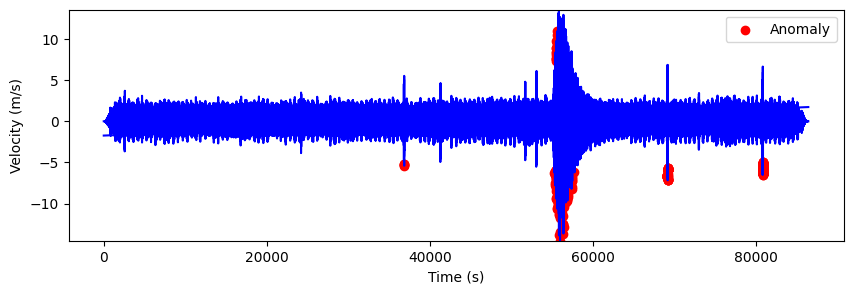

In [96]:

# len(outliers)
len(df['time_rel(sec)'])


# Plot the trace!
fig,ax = plt.subplots(1,1,figsize=(10,3))

ax.plot(df['time_rel(sec)'],normalized_df, c="blue")
ax.scatter(df['time_rel(sec)'], outliers, c="red", label="Anomaly")

ax.set_ylim((np.min(normalized_df), np.max(normalized_df)))
ax.set_ylabel('Velocity (m/s)') 
ax.set_xlabel('Time (s)') 

plt.legend()
plt.show()

In [97]:
data = pd.DataFrame(columns=['avg_chunk_accel', 'label'])
random_forest = RandomForestClassifier()

index = 0
counter = 0
row = 0

DATA = 0
LABEL = 1

for peak in peaks:
    if peak == -1 and counter >= index: 
        start_time = df['time_rel(sec)'][index]
        index += time_slice_size
        sliced_frame = (df[df['time_rel(sec)'].between(start_time, start_time+time_slice_size)])
        vel = sliced_frame['velocity(m/s)']
        
        avg_accel = (vel.iloc[-1] - vel.iloc[0])/len(vel)
        temp = pd.DataFrame(columns=['avg_chunk_accel', 'label'])
        if(start_time+time_slice_size >= activity_detected >= start_time - time_slice_size/2):
            data.loc[row] = [avg_accel,1]
        else:
            data.loc[row] = [avg_accel,0]
        
        row += 1
    if index > len(peaks):
        break
    if index == counter:
        index += 1
        
    counter += 1

In [98]:

act_start = df.index[df['time_rel(sec)'] == sliced_frame.iloc[0]['time_rel(sec)']]
act_end = df.index[df['time_rel(sec)'] == sliced_frame.iloc[-1]['time_rel(sec)']]
trimmed_peaks = peaks[act_start[0]:act_end[0]]
len(trimmed_peaks)

37109

In [105]:
clean_sliced_frame = sliced_frame.drop(['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], axis=1)
normalized_slice = scalar.fit_transform(clean_sliced_frame.values)
normalized_slice

array([[-1.73200413, -7.8575985 ],
       [-1.73191079, -7.83730824],
       [-1.73181744, -7.81701799],
       ...,
       [ 1.73181744,  0.00953973],
       [ 1.73191079,  0.00953941],
       [ 1.73200413,  0.00953903]])

In [133]:
slice_outliers = []
print(trimmed_peaks)
print(len(trimmed_peaks))
i = 0
for val in trimmed_peaks:  
    if val == -1:
        slice_outliers.append(normalized_slice[i][1])
    else:
        slice_outliers.append(100)
    i+= 1
print(i)
slice_outliers = pd.Series(outliers)
print(len(slice_outliers))

[-1 -1 -1 ...  1  1  1]
37109
37109
572427


In [121]:
len(sliced_frame['time_rel(sec)'])

37110

In [122]:
len(slice_outliers[:-4])

572423

ValueError: x and y must be the same size

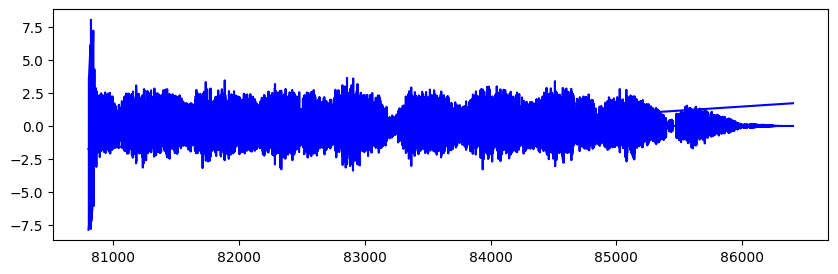

In [104]:
# len(outliers)
len(df['time_rel(sec)'])


# Plot the trace!
fig,ax = plt.subplots(1,1,figsize=(10,3))

ax.plot(sliced_frame['time_rel(sec)'],normalized_slice, c="blue")
ax.scatter(sliced_frame['time_rel(sec)'], slice_outliers, c="red", label="Anomaly")

ax.set_ylim((np.min(normalized_slice), np.max(normalized_slice)))
ax.set_ylabel('Velocity (m/s)') 
ax.set_xlabel('Time (s)') 

plt.legend()
plt.show()

In [14]:
random_forest.fit(pd.DataFrame(data['avg_chunk_accel']), pd.DataFrame(data['label']))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

In [15]:
data

,avg_chunk_accel,label
0,2.318204e-14,0.0
1,2.450532e-14,1.0
2,3.438834e-14,1.0
3,2.308905e-14,0.0
4,4.923401e-14,0.0
